In [93]:
# model creation
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
# from scipy.stats import uniform
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

os.chdir('../data/')

data = pd.read_pickle('procesada/data_plus_census.pkl')
#data = data.query('state=="sp"').dropna()
data = data.dropna()

In [82]:
def model_metrics(model_search):
    print('Best parameters: {0}'.format(model_search.best_params_))
    print('Best score: {0:.3f}'.format(model_search.best_score_))
    print('Best model score in test: {0:.3f}'.format(accuracy_score(y_test, model_search.best_estimator_.predict(X_test))))
    print('Best model ROC in test: {0:.3f}'.format(roc_auc_score(y_test, model_search.best_estimator_.predict_proba(X_test)[:,1])))
    print('Confussion matrix in test:\n')
    print(pd.crosstab(y_test, model_search.best_estimator_.predict(X_test), normalize=True)*100)
    print('Classification report in test: \n')
    print(classification_report(y_test, model_search.best_estimator_.predict(X_test)))

In [65]:
features = data[[x for x in data.columns if data[x].dtype!='object']]
label = pd.to_numeric(data.final_decision=='A').astype(np.int8)

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# Logistic regression

In [66]:
pipeline_logistic = Pipeline([('scaler', StandardScaler()), 
                              ('model', SGDClassifier(loss='log', penalty='elasticnet', random_state=2020, fit_intercept=True))],
                             verbose = False)

In [77]:
params_logistic = {'model__alpha': np.arange(0, 10, 0.2),
                   'model__l1_ratio': np.arange(0.01, 1, 0.02)}

model_logistic = RandomizedSearchCV(pipeline_logistic,
                                    params_logistic, 
                                    random_state=2020,
                                    scoring='accuracy',
                                    cv=5,
                                    n_iter=20,
                                    verbose=1,
                                    n_jobs=5)
model_logistic = model_logistic.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    9.6s finished


In [83]:
model_metrics(model_logistic)

Best parameters: {'model__l1_ratio': 0.15, 'model__alpha': 0.6000000000000001}
Best score: 0.665
Best model score in test: 0.656
Best model ROC in test: 0.768
Confussion matrix in test:

col_0                   0          1
final_decision                      
0               54.600302   3.046757
1               31.342383  11.010558
Classification report in test: 

              precision    recall  f1-score   support

           0       0.64      0.95      0.76      3822
           1       0.78      0.26      0.39      2808

    accuracy                           0.66      6630
   macro avg       0.71      0.60      0.58      6630
weighted avg       0.70      0.66      0.60      6630



# Random forest

In [86]:
rf_acceptance = RandomForestClassifier(n_estimators=50)
pipeline_rf = Pipeline([('scaler', StandardScaler()), 
                        ('select_model', SelectFromModel(rf_acceptance, prefit=False)),
                        ('model', RandomForestClassifier(random_state=2020))],
                       verbose = False)

In [87]:
params_rf = {
    'model__n_estimators': [100, 200, 500],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 5, 10]
}

In [89]:
model_rf = RandomizedSearchCV(pipeline_rf, params_rf, cv=5, random_state=2020, n_iter=5, verbose=1, n_jobs=5)
model_rf = model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:  4.8min finished


In [92]:
model_metrics(model_rf)

Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10}
Best score: 0.732
Best model score in test: 0.730
Best model ROC in test: 0.796
Confussion matrix in test:

col_0                   0          1
final_decision                      
0               46.334842  11.312217
1               15.686275  26.666667
Classification report in test: 

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      3822
           1       0.70      0.63      0.66      2808

    accuracy                           0.73      6630
   macro avg       0.72      0.72      0.72      6630
weighted avg       0.73      0.73      0.73      6630



# XGBoost

In [95]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params_xgb = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'max_depth': [3, 4, 5],
              'n_estimators': [100, 200, 300]
             }

xgb_instace = xgb.XGBClassifier(learning_rate=0.01,
                                objective='binary:logistic')

model_xgb = RandomizedSearchCV(xgb_instace, 
                               params_xgb, 
                               n_iter=15,
                               scoring='roc_auc',
                               n_jobs=5, 
                               cv=5, 
                               verbose=2,
                               random_state=2020)

model_xgb = model_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done  75 out of  75 | elapsed: 10.8min finished


[15:27:43] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [96]:
model_metrics(model_xgb)

Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.8}
Best score: 0.797
Best model score in test: 0.735
Best model ROC in test: 0.798
Confussion matrix in test:

col_0                   0          1
final_decision                      
0               46.304676  11.342383
1               15.173454  27.179487
Classification report in test: 

              precision    recall  f1-score   support

           0       0.75      0.80      0.78      3822
           1       0.71      0.64      0.67      2808

    accuracy                           0.73      6630
   macro avg       0.73      0.72      0.72      6630
weighted avg       0.73      0.73      0.73      6630



In [109]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'eta': 0.01, 'objective': 'binary:logistic',
         'subsample': 0.8, 'min_child_weight': 1,
         'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.8}

# specify validations set to watch performance
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
watchlist = [(dtest, 'eval')]
num_round = 1400

bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=80, verbose_eval=False)

In [119]:
predictions = (bst.predict(dtest)>0.5).astype(np.int8)
accuracy_score(y_test, predictions)

0.736500754147813

# Comparing ROC curves

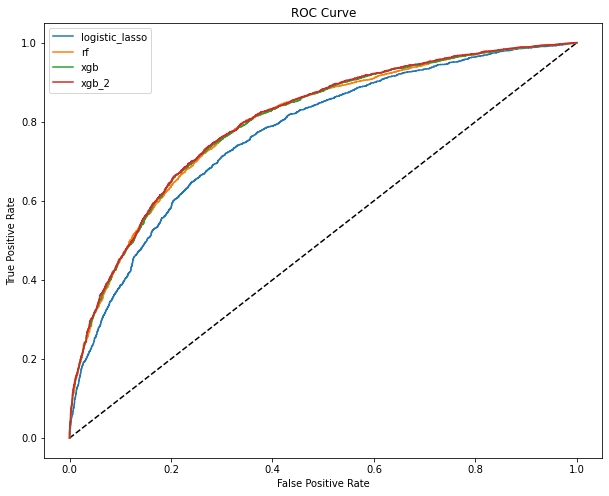

In [118]:
names_models = ['logistic_lasso', 'rf', 'xgb']
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([0, 1], [0, 1], 'k--')
for idx, model_i in enumerate([model_logistic, model_rf, model_xgb]):
    fpr, tpr, thresholds = roc_curve(y_test, model_i.best_estimator_.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=names_models[idx])

fpr, tpr, thresholds = roc_curve(y_test, bst.predict(dtest))
plt.plot(fpr, tpr, label='xgb_2')
ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()